In [687]:
#importando librerías
import numpy as np #para trabajar con los datos en forma de arreglos
import matplotlib.pyplot as plt #para graficar
import scienceplots #estilo de gráficos utilizados
from graphviz import Digraph #para realizar el flowchart
plt.style.use(['science', 'grid']) #estilo de gráfica

In [688]:
#definiendo funciones

#función de kroupa que recibe la cantidad de estrellas, separado por dos rangos de masas (0.08 < M < 0.5) y (0.5 < M < 1)
#y pesándolos de distinta manera (deben haber menos masivas, sino más remanentes que estrellas en MS)
def sample_mass_kroupa(num_stars, m_min=0.08, m_max=100):
    masses = []
    
    #porcentaje de estrellas que caen en cada rango según la IMF de Kroupa
    frac_low_mass = 0.5**(-1.3) / (0.5**(-1.3) + (0.5**(-2.3) - m_max**(-2.3)) / 2.3)
    
    #generar masas para estrellas de baja masa (0.8 - 0.5 M_sun)
    num_low_mass = int(num_stars * frac_low_mass)
    u_low = np.random.uniform(size=num_low_mass)
    m_low = (m_min**(-1.3) + u_low * (0.5**(-1.3) - m_min**(-1.3)))**(-1 / 1.3)
    masses.extend(m_low)

    #generar masas para estrellas de mayor masa (>= 0.5 M_sun)
    num_high_mass = num_stars - num_low_mass
    u_high = np.random.uniform(size=num_high_mass)
    m_high = (0.5**(-2.3) + u_high * (m_max**(-2.3) - 0.5**(-2.3)))**(-1 / 2.3)
    masses.extend(m_high)

    return np.array(masses)

#función para calcular el timepo en la main sequence según
def time_in_MS(masses):
    t_in_ms = (10**10)*(masses**(-2.5))
    return t_in_ms

#función para clasificar tipo de remanentes y obtener sus posiciones en el array de masas iniciales
def type_of_reman(initial_mass_remanents):
    pos_white_dwarf = np.where(initial_mass_remanents < 9)[0]
    pos_neutron_star = np.where((initial_mass_remanents >= 9) & (initial_mass_remanents < 18.5 ))[0]
    pos_black_hole = np.where(initial_mass_remanents >= 18.5 )[0]
    return pos_white_dwarf, pos_neutron_star, pos_black_hole

#función para obtener masas finales de remanentes
def final_masses_WD(intial_masses_WD):
    fmass_WD = 0.109*intial_masses_WD + 0.394 #Kalirai et al 2008 (para enanas blancas)
    return fmass_WD

#funicón para encontrar array de masas finales de las Neutron stars
def final_mass_NS(initial_masses_NS): #Raithel et al 2018 section 5 
    first_cond = np.where((initial_masses_NS >= 9) & (initial_masses_NS <= 13))[0]
    imass_NS_1 = initial_masses_NS[first_cond]
    fmass_NS_1 = (2.24 + 0.508*(imass_NS_1 - 14.75)) + (0.125 * (imass_NS_1 - 14.75)**2) + (0.0110 * (imass_NS_1 - 14.75)**3)

    second_cond = np.where((initial_masses_NS > 13) & (initial_masses_NS < 15))[0]
    imass_NS_2 = initial_masses_NS[second_cond]
    fmass_NS_2 = 0.123 + 0.112*imass_NS_2
    
    thrid_cond = np.where((initial_masses_NS >= 15) & (initial_masses_NS < 17.8))[0]
    imass_NS_3 = initial_masses_NS[thrid_cond]
    fmass_NS_3 = 0.996 + 0.0384*imass_NS_3
    
    fourth_cond = np.where((initial_masses_NS > 17.8) & (initial_masses_NS < 18.5))[0]
    imass_NS_4 = initial_masses_NS[fourth_cond]
    fmass_NS_4 = -0.020 + 0.10*imass_NS_4
    
    fmass_NS = np.concatenate((fmass_NS_1, fmass_NS_2, fmass_NS_3, fmass_NS_4))
    
    return fmass_NS

#función para encontrar el array de masas finales de los Black Holes
def final_mass_BH(initial_masses_BH): #Raithel et al 2018 section 4
    first_cond = np.where((initial_masses_BH >= 18.5) & (initial_masses_BH < 40 ))[0]
    imass_BH_1 = initial_masses_BH[first_cond]
    fmass_BH_1 = -2.049 + (0.4140 * imass_BH_1)
    #M_all = (15.52 - 0.3294 * (imass_BH_1 - 25.97)) - (0.02121 * (imass_BH_1 - 25.97)**2) + (0.003120 * (imass_BH_1 - 25.97)**3)
    #f_ej = 0.9
    #fmass_BH_1 = f_ej*M_core + (1 - f_ej)*M_all
    
    second_cond = np.where((initial_masses_BH >= 40) & (initial_masses_BH <= 100 ))[0]
    imass_BH_2 = initial_masses_BH[second_cond]
    fmass_BH_2 = 5.697 + (7.8598 * 10**8 * (imass_BH_2)**(-4.858))
    
    fmass_BH = np.concatenate((fmass_BH_1, fmass_BH_2))
    
    return fmass_BH

In [689]:
#cantidades de estrellas a comparar
stars_number = np.asarray([100, 1000, 10000, 100000, 1000000])

In [690]:
#defino un array de las estrellas que pasarán por la IMF de Kroupa, para obtener las masas iniciales que sigan la IMF
initial_masses = np.array([sample_mass_kroupa(stars_number[0]), sample_mass_kroupa(stars_number[1]), sample_mass_kroupa(stars_number[2]), sample_mass_kroupa(stars_number[3]), sample_mass_kroupa(stars_number[4])], dtype=object) 

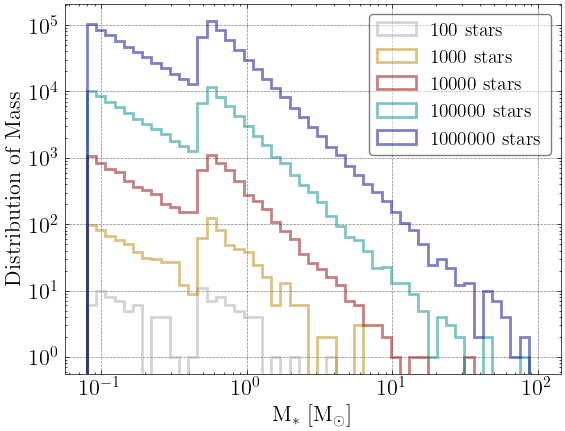

Cantidad total de estrellas en el rango [0.08, 100] [M_sun]:  100
Cantidad total de estrellas en el rango [0.08, 100] [M_sun]:  1000
Cantidad total de estrellas en el rango [0.08, 100] [M_sun]:  10000
Cantidad total de estrellas en el rango [0.08, 100] [M_sun]:  100000
Cantidad total de estrellas en el rango [0.08, 100] [M_sun]:  1000000


In [691]:
fig = plt.figure(figsize = (6.4, 4.8))
ax = fig.subplots()
colors = ['darkgray', 'darkgoldenrod', 'darkred', 'darkcyan', 'darkblue']
bins = np.logspace(np.log10(0.08), np.log10(100), 50)
for count, i in enumerate(initial_masses):
    ax.hist(i, color = colors[count], bins = bins, histtype = "step", lw = 2, alpha = 0.5, label = str(stars_number[count])+' stars')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'M$_*$ [M$_{\odot}$]')
ax.set_ylabel(r' Distribution of Mass')
ax.legend(edgecolor = 'black', framealpha = .5, fontsize = 14)
plt.savefig('Imagenes/IMF_Kroupa.png', dpi = 600)
plt.show()

for i in stars_number:                                                         
    print(r'Cantidad total de estrellas en el rango [0.08, 100] [M_sun]: ', i)

In [692]:
#asignar edad de nacimiento a mis estrellas (según cantidad de estrellas)
Gyrs = []
for i in stars_number:
    Gyrs.append(np.random.uniform(0, 10, i))
Gyrs = np.asarray(Gyrs, dtype = 'object')

#sfr constante extraido de D. Elia et al 2022 The star Formation Rate of the milky way 2.0 +- 0.7 [M_sun/yr] 
sfr = []
for i in stars_number:
    sfr.append(np.random.uniform(1.3, 2.7, i))
sfr = np.asarray(sfr, dtype = 'object')

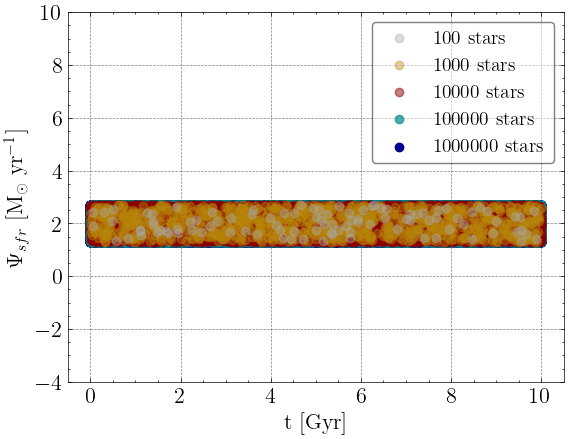

Vemos que la SFR es constante a lo largo de 10 Gyr, para todas las cantidades de estrellas (mientras más estrellas más uniforme la distribución, por ende, más constante es la SFR)


In [693]:
fig = plt.figure(figsize = (6.4, 4.8))
ax = fig.subplots()
zorder = [5,4,3,2,1]
alpha = [0.4, 0.4, 0.5, 0.7, 1]

for i in range(0, len(Gyrs)):
    ax.scatter(Gyrs[i], sfr[i], zorder = zorder[i], color = colors[i], label = str(stars_number[i])+' stars', alpha = alpha[i])

ax.set_xlabel(r't [Gyr]')
ax.set_ylabel(r'$\Psi_{sfr}$ [M$_{\odot}$ yr$^{-1}$]')
ax.set_ylim(-4, 10)
ax.legend(edgecolor = 'black', framealpha = .5, fontsize = 14)
plt.savefig('Imagenes/SFR_vs_time.png', dpi = 600) #para guardar la imagen, se debe tener una carpeta llamada "Imagenes" en el directorio
plt.show()
print('Vemos que la SFR es constante a lo largo de 10 Gyr, para todas las cantidades de estrellas (mientras más estrellas más uniforme la distribución, por ende, más constante es la SFR)')

In [694]:
#obteniendo tiempo en la Main Sequence (con función descrita arriba) y edad de la estrella con su birth time (variable Gyrs)
tiempo_in_MS = []
for i in initial_masses:
    tiempo_in_MS.append(time_in_MS(i))
tiempo_in_MS = np.asarray(tiempo_in_MS, dtype = 'object')

edad_estrella = []
for i in Gyrs:
    edad_estrella.append((10 - i)*10**9)
edad_estrella = np.asarray(edad_estrella, dtype = 'object')

In [695]:
#sacar edad de estrella y ver si es remanente
remanent_pos = []
no_reman_pos = []
for i in range(0, len(stars_number)):
    remanent_pos.append(np.where(tiempo_in_MS[i] <= edad_estrella[i])[0])
    no_reman_pos.append(np.where(tiempo_in_MS[i] > edad_estrella[i])[0])
remanent_pos = np.asarray(remanent_pos, dtype = 'object')
no_reman_pos = np.asarray(no_reman_pos, dtype = 'object')

#obtener las masas de las no remanentes (será aproximadamente igual a la mesa que tendrá cuando termine la MS)
MS_masses = []
for count, i in enumerate(initial_masses):
    MS_masses.append(i[no_reman_pos[count]])
MS_masses = np.asarray(MS_masses, dtype = 'object')

#obtener las masas iniciales de todos los remanentes estelares que tengo
initial_masses_remanents = []
for i in range(0, len(stars_number)):
    initial_masses_remanents.append(initial_masses[i][remanent_pos[i]])
initial_masses_remanents = np.asarray(initial_masses_remanents, dtype = 'object')

for count, i in enumerate(stars_number):
    print(f'El porcentaje de la cantidad de remanentes, con respecto al total de estrellas para {i} estrellas, corresponde a: '+ str(round(len(remanent_pos[count])/len(Gyrs[count]) * 100, 2))+'%')

El porcentaje de la cantidad de remanentes, con respecto al total de estrellas para 100 estrellas, corresponde a: 3.0%
El porcentaje de la cantidad de remanentes, con respecto al total de estrellas para 1000 estrellas, corresponde a: 5.4%
El porcentaje de la cantidad de remanentes, con respecto al total de estrellas para 10000 estrellas, corresponde a: 4.99%
El porcentaje de la cantidad de remanentes, con respecto al total de estrellas para 100000 estrellas, corresponde a: 4.89%
El porcentaje de la cantidad de remanentes, con respecto al total de estrellas para 1000000 estrellas, corresponde a: 4.95%


In [696]:
#para obtener las masas iniciales separado por tipo de remanente
initial_masses_WD = []
initial_masses_NS = []
initial_masses_BH = []
for count, i in enumerate(initial_masses_remanents):
    pos_white_dwarf, pos_neutron_star, pos_black_hole = type_of_reman(i)
    initial_masses_WD.append(i[pos_white_dwarf])
    initial_masses_NS.append(i[pos_neutron_star])
    initial_masses_BH.append(i[pos_black_hole])
    
initial_masses_WD = np.asarray(initial_masses_WD, dtype = 'object')
initial_masses_NS = np.asarray(initial_masses_NS, dtype = 'object')
initial_masses_BH = np.asarray(initial_masses_BH, dtype = 'object')

In [697]:
#para obtener las masas finales de cada remanente según ecuaciones de papers
fmass_WD = []
for i in initial_masses_WD:
    fmass_WD.append(final_masses_WD(i))
fmass_WD = np.asarray(fmass_WD, dtype = 'object')

f_mass_NS = []
for i in initial_masses_NS:
    f_mass_NS.append(final_mass_NS(i))
f_mass_NS = np.asarray(f_mass_NS, dtype = 'object')

f_mass_BH = []
for i in initial_masses_BH:
    f_mass_BH.append(final_mass_BH(i))
f_mass_BH = np.asarray(f_mass_BH, dtype = 'object')

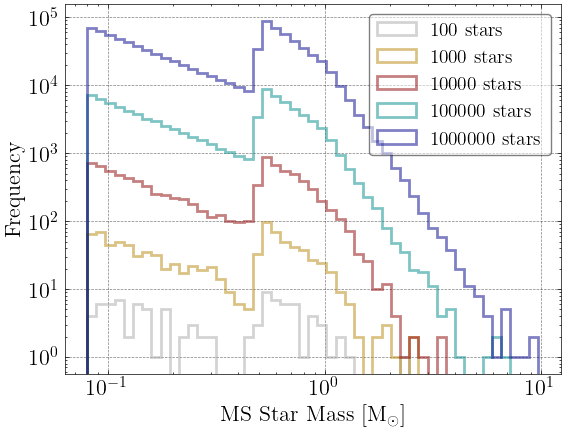

In [698]:
fig = plt.figure(figsize = (6.4, 4.8))
ax = fig.subplots()
bins_MS = np.logspace(np.log10(min(MS_masses[4])), np.log10(max(MS_masses[4])), 50)
for count, i in enumerate(MS_masses):
    ax.hist(i, color = colors[count], bins = bins_MS, histtype = "step", lw = 2, alpha = 0.5, label = str(stars_number[count])+' stars')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Frequency')
ax.set_xlabel(r'MS Star Mass [M$_{\odot}$]')
ax.legend(edgecolor = 'black', framealpha = .5, fontsize = 14)
plt.savefig('Imagenes/dist_MS_mass.png', dpi = 600)
plt.show()

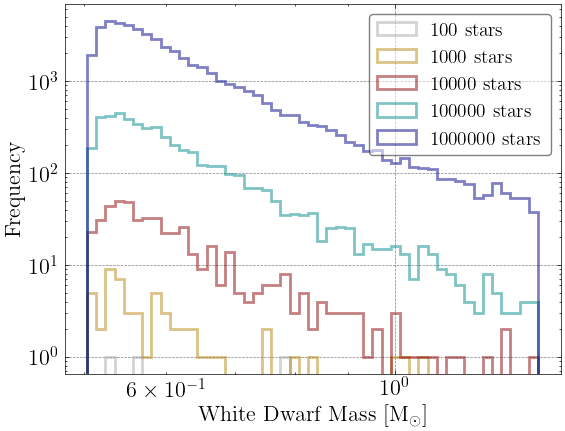

In [699]:
fig = plt.figure(figsize = (6.4, 4.8))
ax = fig.subplots()
bins_WD = np.logspace(np.log10(min(fmass_WD[4])), np.log10(max(fmass_WD[4])), 50)
for count, i in enumerate(fmass_WD):
    ax.hist(i, color = colors[count], bins = bins_WD, histtype = "step", lw = 2, alpha = 0.5, label = str(stars_number[count])+' stars')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Frequency')
ax.set_xlabel(r'White Dwarf Mass [M$_{\odot}$]')
ax.legend(edgecolor = 'black', framealpha = .5, fontsize = 14)
plt.savefig('Imagenes/dist_WD_mass.png', dpi = 600)
plt.show()

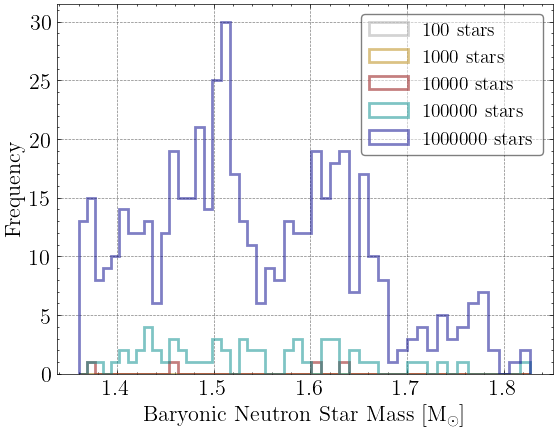

In [700]:
fig = plt.figure(figsize = (6.4, 4.8))
ax = fig.subplots()
bins_NS = np.logspace(np.log10(min(f_mass_NS[4])), np.log10(max(f_mass_NS[4])), 50)
for count, i in enumerate(f_mass_NS):
    ax.hist(i, color = colors[count], bins = bins_NS, histtype = "step", lw = 2, alpha = 0.5, label = str(stars_number[count])+' stars')
ax.set_ylabel('Frequency')
ax.set_xlabel(r'Baryonic Neutron Star Mass [M$_{\odot}$]')
ax.legend(edgecolor = 'black', framealpha = .5, fontsize = 14)
plt.savefig('Imagenes/dist_neutron_mass.png', dpi = 600)
plt.show()

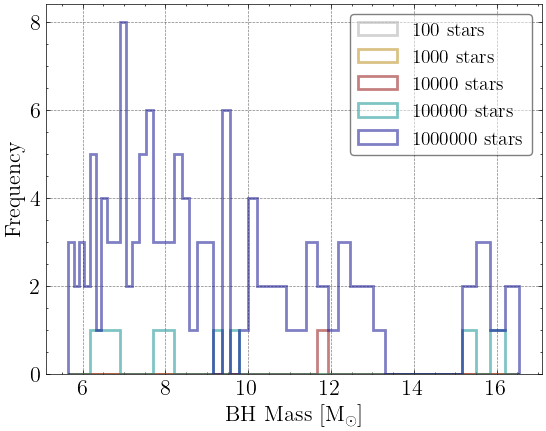

In [701]:
fig = plt.figure(figsize = (6.4, 4.8))
ax = fig.subplots()
bins_BH = np.logspace(np.log10(min(f_mass_BH[4])), np.log10(max(f_mass_BH[4])), 50)
for count, i in enumerate(f_mass_BH):
    ax.hist(i, color = colors[count], bins = bins_BH, histtype = "step", lw = 2, alpha = 0.5, label = str(stars_number[count])+' stars')
ax.set_ylabel('Frequency')
ax.set_xlabel(r'BH Mass [M$_{\odot}$]')
ax.legend(edgecolor = 'black', framealpha = .5, fontsize = 14)
plt.savefig('Imagenes/dist_BH_mass.png', dpi = 600)
plt.show()

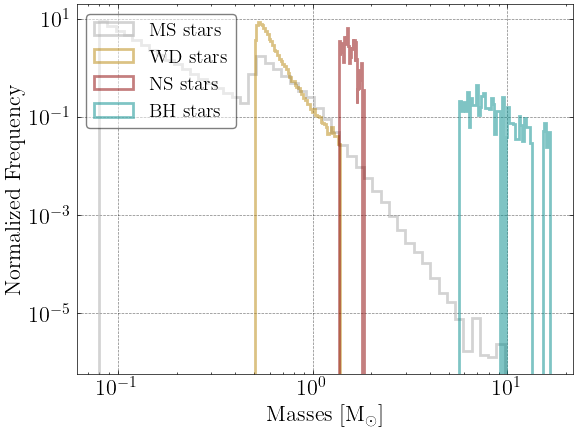

In [702]:
fig = plt.figure(figsize = (6.4, 4.8))
ax = fig.subplots()
total_masses = len(MS_masses[4]) + len(fmass_WD[4]) + len(f_mass_NS[4]) + len(f_mass_BH[4])
ax.hist(MS_masses[4], color = colors[0], bins = bins_MS, histtype = "step", lw = 2, alpha = 0.5, label = 'MS stars', density = True)
ax.hist(fmass_WD[4], color = colors[1], bins = bins_WD, histtype = "step", lw = 2, alpha = 0.5, label = 'WD stars', density = True)
ax.hist(f_mass_NS[4], color = colors[2], bins = bins_NS, histtype = "step", lw = 2, alpha = 0.5, label = 'NS stars', density = True)
ax.hist(f_mass_BH[4], color = colors[3], bins = bins_BH, histtype = "step", lw = 2, alpha = 0.5, label = 'BH stars', density = True)

ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim(0, 18)
ax.set_ylabel('Normalized Frequency')
ax.set_xlabel(r'Masses [M$_{\odot}$]')
ax.legend(edgecolor = 'black', framealpha = .5, fontsize = 14)
plt.savefig('Imagenes/normalized.png', dpi = 600)
plt.show()

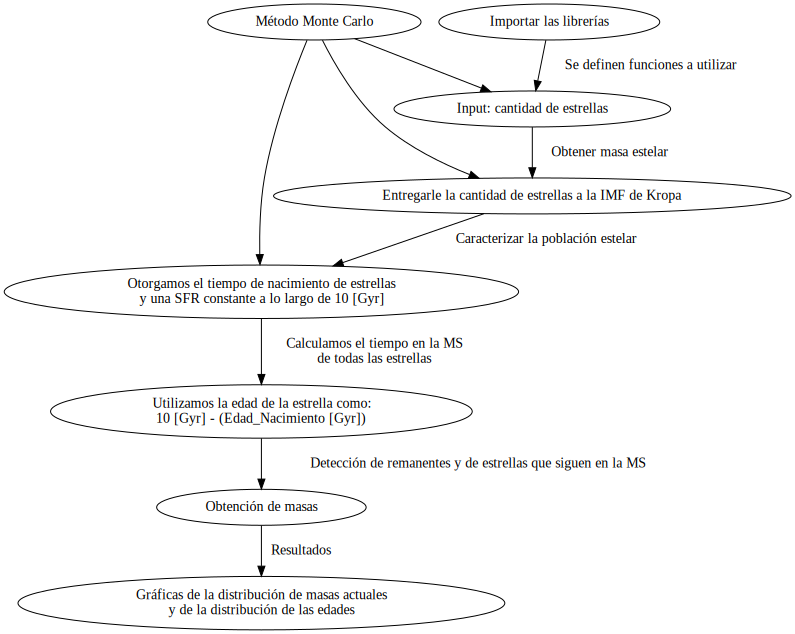

In [705]:
#código para crear flowchart
dot = Digraph(comment='Flowchart del código Monte Carlo para población estelar')

#añadir nodos principales del código
dot.node('A', 'Método Monte Carlo')
dot.node('B', 'Importar las librerías')
dot.node('C', 'Input: cantidad de estrellas')
dot.node('D', 'Entregarle la cantidad de estrellas a la IMF de Kropa')
dot.node('E', r'Otorgamos el tiempo de nacimiento de estrellas \n y una SFR constante a lo largo de 10 [Gyr]')
dot.node('F', r'Utilizamos la edad de la estrella como: \n 10 [Gyr] - (Edad_Nacimiento [Gyr])')
dot.node('G', 'Obtención de masas')
dot.node('H', r'Gráficas de la distribución de masas actuales \n y de la distribución de las edades')

#hacemos las conexiones entre las funciones según el flujo lógico
dot.edge('B', 'C', label = 'Se definen funciones a utilizar')
dot.edge('C', 'D', label = 'Obtener masa estelar')
dot.edge('D', 'E', label = 'Caracterizar la población estelar')
dot.edge('E', 'F', label = r'Calculamos el tiempo en la MS \n de todas las estrellas')
dot.edge('F', 'G', label = 'Detección de remanentes y de estrellas que siguen en la MS')
dot.edge('G', 'H', label = 'Resultados')

dot.edge('A', 'C')
dot.edge('A', 'D')
dot.edge('A', 'E')

#convertirlo a png y guardarlo
dot.render("Distribucion_pob_est", format="png", view=False)

dot